# **Convolutional Autoencoder**

In [ ]:
# import libraries

import os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [ ]:
# defining the key parameters
batch_size = 100
original_dim = 784 # x: 28x28
latent_dim = 2 # z
intermediate_dim = 256 # h
epochs = 50

In [ ]:
print(f'tensorflow version = {tf.__version__}')
print(f'keras version = {keras.__version__}')

# Countermeasures for version inconsistencies
tf.compat.v1.disable_eager_execution()

tensorflow version = 2.7.0
keras version = 2.7.0


**Defining the encoder** 

In [ ]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer (hidden layer 1)
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space (code layer)
z = Dense(latent_dim, name="z")(h)

# define and print out summary of the encoder
encoder = Model(x, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoding (Dense)            (None, 256)               200960    
                                                                 
 z (Dense)                   (None, 2)                 514       
                                                                 
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________


**Defining the decoder**

In [ ]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension (hidden layer 2)
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)

# # define and print out summary of the decoder
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


**Definition of the AE: Combining the encoder and the decoder**

In [ ]:
# Combining the encoder and decoder.

output_combined = decoder(encoder(x))
# link the input and the overall output
AE = Model(x, output_combined)
# print out what the overall model looks like
AE.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 2)                 201474    
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0
_________________________________________________________________


**Definition of the loss function** 

Total loss is the binary-cross-entropy (BCE) loss (as a reconstruction error)

$L_{total}=L_{BCE}$

In BCE loss, each pixel value is consedered as a probability 

In [ ]:
def AE_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor, 
            original_dim=original_dim):
    BCE_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    AE_loss = K.mean(BCE_loss)
    return AE_loss

AE.compile(optimizer='rmsprop', loss=AE_loss)
AE.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 2)                 201474    
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0
_________________________________________________________________


**Loading MNIST dataset** 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

**Chek the data size and contents** 

In [ ]:
print(f'x_train.shape {x_train.shape}')
print(f'x_test.shape {x_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

x_train.shape (60000, 784)
x_test.shape (10000, 784)
y_train.shape (60000,)
y_test.shape (10000,)


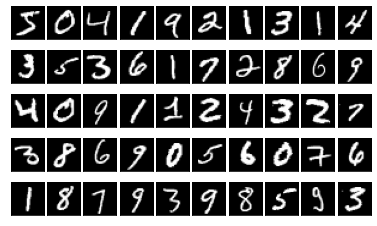

y_train=[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3]


In [ ]:
# display MNIST data
W = 10  # number of images in width
H = 5   # number of images in height
fig = plt.figure(figsize=(H, W))
fig.subplots_adjust(left=0, right=1, bottom=0,
                    top=0.3, hspace=0.10, wspace=0.10)
for i in range(W*H):
    ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape(28,-1), cmap='gray')

plt.show()
#print(F'x_train {x_train[0:10][0:10]}')
print(F'y_train={y_train[0:W*H]}')

## ***Visualize the digits***

In [ ]:
def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

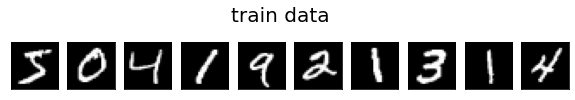

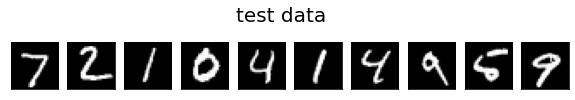

In [ ]:
show_data(x_train, title="train data")
show_data(x_test, title="test data")

**Train the Autoencoder**

In [ ]:
AE.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs, 
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 113us/sample - loss: 176.9899
Epoch 2/50
60000/60000 [==============================] - 6s 106us/sample - loss: 160.1688
Epoch 3/50
60000/60000 [==============================] - 6s 108us/sample - loss: 156.5824
Epoch 4/50
60000/60000 [==============================] - 6s 106us/sample - loss: 154.1044
Epoch 5/50
60000/60000 [==============================] - 6s 107us/sample - loss: 152.1951
Epoch 6/50
60000/60000 [==============================] - 6s 107us/sample - loss: 150.8080
Epoch 7/50
60000/60000 [==============================] - 6s 106us/sample - loss: 149.7339
Epoch 8/50
60000/60000 [==============================] - 6s 106us/sample - loss: 148.8654
Epoch 9/50
60000/60000 [==============================] - 6s 106us/sample - loss: 148.1875
Epoch 10/50
60000/60000 [==============================] - 7s 109us/sample - loss: 147.5779
Epoch 11/50
60000/60000 [==============================] - 7s 109u

**Check the distribution of x_test in the latent feature space (z: 2dim)**

We can see the distibution of 2D embedding (z).\ We can see that the same numbers are distributed close together.

**784dim of the input information is compressed to only 2dim!**

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


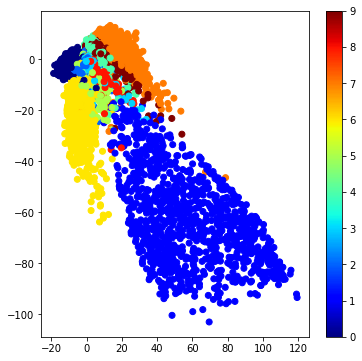

In [ ]:
# display a 2D plot of the digit classes in the latent space (first 2dim)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

**Let us see the reconstructed images from the latent space**

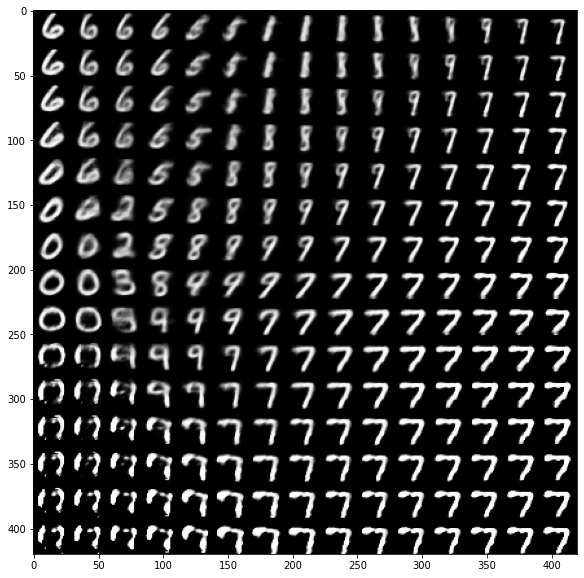

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# change the range of visialization according to the above results. 
grid_y = np.linspace(-10, 50, n)
grid_x = np.linspace(-20, 20, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

**Get the decoded (reconstructed data)**

In [ ]:
decoded_data = AE.predict(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


**Make a model to get the encoded representation (i.e. intermediate layer output for a given input)**

Making the half model of our actual model

The input = our acutal model input

The output = code layer "z" (see enconder)

In [ ]:
get_encoded_data = Model(inputs = AE.input, outputs = AE.get_layer("encoder").outputs)

**Get the encoded data**

In [ ]:
encoded_data = get_encoded_data.predict (x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


**Visualize the results on test set**

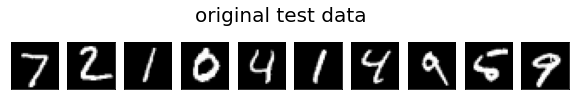

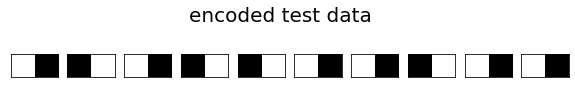

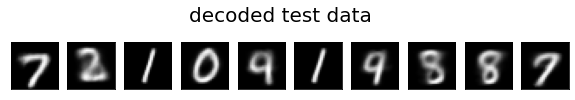

In [ ]:
show_data(x_test, title = "original test data")
show_data(encoded_data, height =1, width=2, title = "encoded test data")
show_data(decoded_data, title="decoded test data")

In [ ]:
encoder.layers[2].get_weights()

[array([[ 1.56466007e+00, -9.77473319e-01],
        [ 2.93023467e-01, -1.02967870e+00],
        [ 1.30979240e+00, -8.58707130e-01],
        [ 1.70843208e+00, -1.38521576e+00],
        [-1.01929434e-01, -4.50085960e-02],
        [ 1.42516494e+00, -8.28569889e-01],
        [ 1.87154841e+00, -1.54412961e+00],
        [ 1.96230695e-01, -1.90182894e-01],
        [-1.23668432e-01,  1.15391344e-01],
        [-1.28756255e-01, -1.97252706e-02],
        [ 7.58924186e-01, -1.15906544e-01],
        [-3.58865082e-01,  3.36453468e-02],
        [ 6.19349957e-01, -1.42852759e+00],
        [-1.51262134e-01, -1.14383721e+00],
        [ 7.49890029e-01,  1.15296379e-01],
        [-1.32010818e-01,  1.09157460e-02],
        [ 7.94736862e-01, -1.24737211e-01],
        [ 9.14160728e-01, -2.17559934e-02],
        [-5.83172292e-02,  5.86906299e-02],
        [-3.41667056e-01,  4.94564958e-02],
        [-1.85207620e-01, -6.05044179e-02],
        [ 1.87856889e+00, -4.53505963e-01],
        [ 4.97367650e-01,  1.874

In [ ]:
encoder.layers[2].output()

TypeError: ignored